In [1]:
import os
import sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib 
plt.rcParams['font.family'] = 'Times New Roman'
plt.style.use('tableau-colorblind10') #seaborn-v0_8-whitegrid

In [2]:
lcia_icevd = pd.read_excel("output/ICEVd_V1A.xlsx")
lcia_bev = pd.read_excel("output/BEV_V1A_V1B.xlsx", index_col = None )

In [3]:
lcia_bev.head()

,SSP,Year,Bat_tech,IPCC_GWP100,premise_GWP100,pGWP100
0,ssp119,2030,NMC622,177826.645604,182908.570336,179060.507296
1,ssp119,2030,LFP,167226.777071,170649.031771,167228.071545
2,ssp119,2030,LTO,200100.835461,205924.481911,201989.634646
3,ssp119,2030,NCA,170804.973391,178041.387302,174523.363763
4,ssp119,2040,NMC622,147318.151655,150467.783374,148202.722438


In [4]:
lcia_bev_nmc = lcia_bev[ lcia_bev["Bat_tech"] == "NMC622" ]
#lcia_bev_nmc

In [5]:
filter_bb = []
for yr in [2030, 2040, 2050]: 
    for sp in ['ssp119',  'ssp245', 'ssp585']: 
        bb = lcia_bev[(lcia_bev['SSP'] == sp) & (lcia_bev['Year'] == yr)]
        min_index = bb["pGWP100"].idxmin()
        bb_best = bb.loc[min_index]
        filter_bb.append(bb_best)
        
lcia_bevbest = pd.DataFrame(filter_bb)
#lcia_bevbest

In [6]:
lcia_bevbest.sort_values("SSP")

,SSP,Year,Bat_tech,IPCC_GWP100,premise_GWP100,pGWP100
1,ssp119,2030,LFP,167226.777071,170649.031771,167228.071545
8,ssp119,2040,LSB,128219.084880,129934.014084,128014.377164
13,ssp119,2050,LSB,114190.579859,114041.666237,112523.797369
29,ssp245,2030,LFP,183766.790902,187520.626919,183125.323799
36,ssp245,2040,LSB,150161.761963,153744.804167,151278.599126
41,ssp245,2050,LSB,133945.106752,137555.281483,136205.974041
43,ssp585,2030,LFP,195585.310117,199313.809386,193599.553189
47,ssp585,2040,LFP,184799.030631,188620.043834,183655.857844
51,ssp585,2050,LFP,156577.020758,160377.500190,157749.910889


In [7]:
#best_bat label to be used in plot: 
bat_lable = lcia_bevbest.sort_values("SSP")['Bat_tech'].values

### create ordered new DF for each SSP[x], v_year, to be used in plot, total df_plot list len = 12

In [19]:
df_plot=[]
for sp in ['ssp119', 'ssp245', 'ssp585']: 
    for yr in [2030, 2040, 2050]: 
        v_type = ['BEV','BEV', 'ICEV', 'ICEV'] 
        LCIA_type = ['premiseGWP100', 'pGWP100', 'premiseGWP100', 'pGWP100' ]
        bevs1 = lcia_bevbest[(lcia_bevbest['SSP'] == sp) & (lcia_bevbest['Year'] == yr)]['premise_GWP100'].values[0]
        bevs2 = lcia_bevbest[(lcia_bevbest['SSP'] == sp) & (lcia_bevbest['Year'] == yr)]['pGWP100'].values[0]
        icev1 = lcia_icevd[(lcia_icevd['SSP'] == sp) & (lcia_icevd['Year'] == yr)]['premise_GWP100'].values[0]
        icev2 = lcia_icevd[(lcia_icevd['SSP'] == sp) & (lcia_icevd['Year'] == yr)]['pGWP100'].values[0]
        score_col = [bevs1, bevs2, icev1,icev2] 
        df = pd.DataFrame( zip([sp]*4 , [yr]*4, v_type, LCIA_type, score_col) , columns = ["SSP", "Year", "powertrain", "LCIA_m", "kgCO2e_per_truck"])
        df.loc[:, 'tCO2e_per_truck'] =  df['kgCO2e_per_truck'] / 1000 
        df_plot.append(df)

In [20]:
#df
df_plot[0]

,SSP,Year,powertrain,LCIA_m,kgCO2e_per_truck,tCO2e_per_truck
0,ssp119,2030,BEV,premiseGWP100,170649.031771,170.649032
1,ssp119,2030,BEV,pGWP100,167228.071545,167.228072
2,ssp119,2030,ICEV,premiseGWP100,101192.073576,101.192074
3,ssp119,2030,ICEV,pGWP100,99125.053226,99.125053


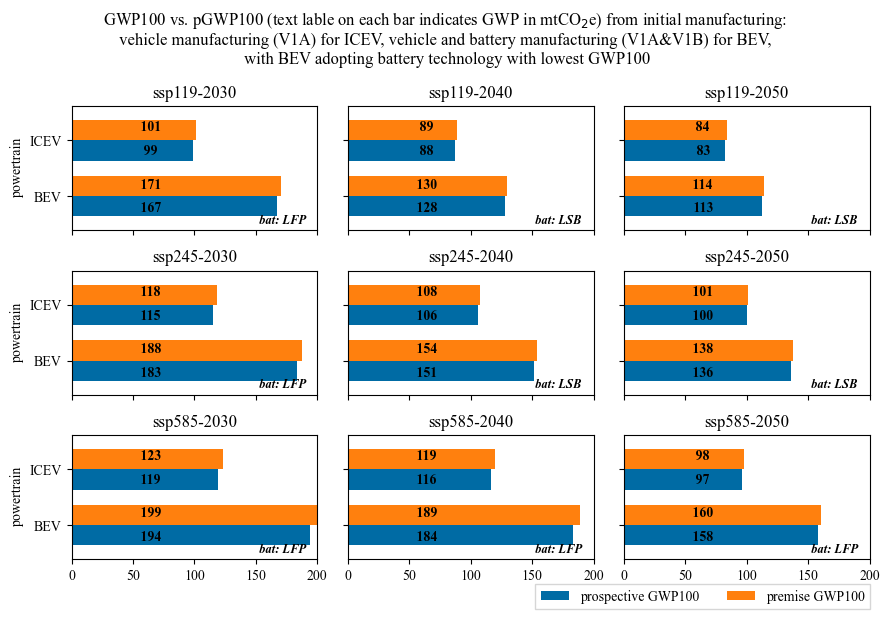

In [37]:
fig, axs = plt.subplots(3, 3, figsize=(9, 6))

# Flatten the axs array to iterate over the subplots
axs = axs.flatten()

for i in range(len(df_plot)) :

    ax = axs[i]
    axs[i].grid(True, linestyle='--', linewidth=0.5, color='gray')
    axs[i].set_xlim(0,200) 
    
    df = df_plot[i]
    ddf = df[['powertrain', 'LCIA_m', 'tCO2e_per_truck']]    
    pivot_df = ddf.pivot_table(index='powertrain', columns='LCIA_m', values='tCO2e_per_truck', aggfunc='sum')
    subtitle = str(df["SSP"][0]) + "-" + str(df["Year"][0] )
    
    pivot_df.plot(kind='barh', ax=ax, legend=False, title =subtitle, width=0.73 )
    axs[i].set_title(subtitle)
    
    bev_prem_gwp100 = int(round(df.iloc[0,4]/1000, 0))
    bev_p_gwp100= int(round(df.iloc[1,4]/1000, 0))
    icev_prem_gwp100 = int(round(df.iloc[2,4]/1000, 0))
    icev_p_gwp100 = int(round(df.iloc[3,4]/1000, 0))
    axs[i].text(63, -0.23, f' {bev_p_gwp100}', ha='center', va='center', fontsize=10, fontweight='bold', color='black')
    axs[i].text(63, 0.2, f' {bev_prem_gwp100}', ha='center', va='center', fontsize=10, fontweight='bold', color='black')
    axs[i].text(63, 0.8, f' {icev_p_gwp100}', ha='center', va='center', fontsize=10, fontweight='bold', color='black')
    axs[i].text(63, 1.23, f' {icev_prem_gwp100}', ha='center', va='center', fontsize=10, fontweight='bold', color='black')
    ### adding what best battery is adopted: 
    axs[i].text(150, -0.5 , f' bat: {bat_lable[i]} ',  fontsize=9, fontweight='bold', color='black', fontstyle='italic')

    # Set y-axis to nothing if not left panels
    if i % 3 != 0:  
        axs[i].set_yticklabels([])
        axs[i].set_ylabel('') 

    """
    if i == 0 or i == 3 or i == 6 :  
        axs[i].set_xlim(0,200) 
    if i == 1 or i == 4 or i == 7 :   
        axs[i].set_xlim(0,200) 
    if i == 2 or i == 5 or i == 8 :  
        axs[i].set_xlim(0,165) 
    """   
    if i<6:
            axs[i].set_xticklabels([])  
    
label = ['prospective GWP100', 'premise GWP100']
#label[9] = "switch_P: gtruck_BEV_battery_tech"
fig.legend(label, loc='lower right', bbox_to_anchor=(0.98, -0.03), fancybox=False,  ncol=2)
tt1 = r'GWP100 vs. pGWP100 (text lable on each bar indicates GWP in mtCO$_2$e) from initial manufacturing:' 
tt2 = '\n vehicle manufacturing (V1A) for ICEV, vehicle and battery manufacturing (V1A&V1B) for BEV, \n with BEV adopting battery technology with lowest GWP100'
fig.suptitle(tt1+tt2, fontsize=12)
plt.tight_layout()

plt.savefig('output/Fig6_GWP100vsPGWP100.jpg', dpi=300, bbox_inches='tight')
plt.show()